In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import os
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import shutil
import random as rn
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Mengunggah file kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/leukemia-classification --force

100% 865M/867M [00:12<00:00, 53.2MB/s]
100% 867M/867M [00:12<00:00, 71.5MB/s]


In [ ]:
!unzip leukemia-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_4_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/

In [ ]:
DATASET_PATH = "/content/C-NMC_Leukemia"
TRAINING_PATH = os.path.join(DATASET_PATH, 'training_data')

# Path untuk folder0
TRAINING_ALL_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'all')
TRAINING_HEM_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'hem')

# Path untuk folder1
TRAINING_ALL_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'all')
TRAINING_HEM_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'hem')

# Path untuk folder2
TRAINING_ALL_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'all')
TRAINING_HEM_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'hem')

# Path untuk folder validasi
VALIDATION_PATH = os.path.join(DATASET_PATH, 'validation_data', 'C-NMC_test_prelim_phase_data')

# Path untuk folder pengujian
TEST_PATH = os.path.join(DATASET_PATH, 'testing_data', 'C-NMC_test_final_phase_data')


LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/models/vgg16"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300

In [ ]:
def set_seed ():
  '''
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    os.path.join(TRAINING_PATH, 'fold_0'),
    image_size = (image_height, image_width), # 300x300
    batch_size = batch_size,
    shuffle = True,
    seed = 123
    )

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'validation_data'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True,
    seed = 123
    )

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'testing_data'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True,
    seed = 123
    )

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model(model):
    '''
    evaluate_model is used to plot some statistics about the performance on the test set
    :param model: model to consider
    '''
    y_score = model.predict(test_dataset)
    y_pred = np.rint(y_score)  # to have 0 or 1
    y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis=0)
    print("Classification report: ")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [ ]:
shapes = {}

total_entries = []
entries = os.listdir(TRAINING_ALL_PATH_0)
total_entries += entries
for entry in tqdm(entries):
  img = cv2.imread(TRAINING_ALL_PATH_0 + '/' + entry)
  if img.shape <= (300, 300):
    shapes[(300,300)] = shapes.get((300,300), 0) + 1
  if img.shape <= (299, 299): # like Inception and Xception
    shapes[(299,299)] = shapes.get((299,299), 0) + 1
  if img.shape <= (224, 224): # like ResNet, DenseNet, VGG, EfficientNet
    shapes[(224,224)] = shapes.get((224,224), 0) + 1
entries = os.listdir(TRAINING_HEM_PATH_0)
total_entries += entries
for entry in tqdm(entries):
  img = cv2.imread(TRAINING_HEM_PATH_0 + '/' + entry)
  if img.shape <= (300, 300):
    shapes[(300,300)] = shapes.get((300,300), 0) + 1
  if img.shape <= (299, 299):
    shapes[(299,299)] = shapes.get((299,299), 0) + 1
  if img.shape <= (224, 224):
    shapes[(224,224)] = shapes.get((224,224), 0) + 1

  0%|          | 0/2397 [00:00<?, ?it/s]

  0%|          | 0/1130 [00:00<?, ?it/s]

In [ ]:
print("Number of training images: ", len(total_entries))
print("Common shapes: ", shapes)

Number of training images:  3527
Common shapes:  {}


In [ ]:
set_seed()

train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 3527 files belonging to 2 classes.
Found 1867 files belonging to 1 classes.
Found 2586 files belonging to 1 classes.


In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

compile_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                        

Epoch 1/30
111/111 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.7528
Epoch 1: val_loss improved from inf to 0.18521, saving model to /content/models/OneDense256_1dropout.h5
111/111 [==============================] - 31s 167ms/step - loss: 0.5248 - accuracy: 0.7528 - val_loss: 0.1852 - val_accuracy: 0.9523
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/111 [============================>.] - ETA: 0s - loss: 0.4676 - accuracy: 0.8080
Epoch 2: val_loss did not improve from 0.18521
111/111 [==============================] - 15s 135ms/step - loss: 0.4672 - accuracy: 0.8081 - val_loss: 0.3235 - val_accuracy: 0.8532
Epoch 3/30
110/111 [============================>.] - ETA: 0s - loss: 0.4537 - accuracy: 0.8199
Epoch 3: val_loss did not improve from 0.18521
111/111 [==============================] - 17s 146ms/step - loss: 0.4537 - accuracy: 0.8200 - val_loss: 0.3085 - val_accuracy: 0.8902
Epoch 4/30
110/111 [============================>.] - ETA: 0s - loss: 0.4492 - accuracy: 0.8199
Epoch 4: val_loss did not improve from 0.18521
111/111 [==============================] - 15s 135ms/step - loss: 0.4493 - accuracy: 0.8200 - val_loss: 0.2581 - val_accuracy: 0.9175
Epoch 5/30
110/111 [============================>.] - ETA: 0s - loss: 0.4254 - accuracy: 0.8233
Epoch 5: val_loss did not improve from 0.18521
111/111 [============================

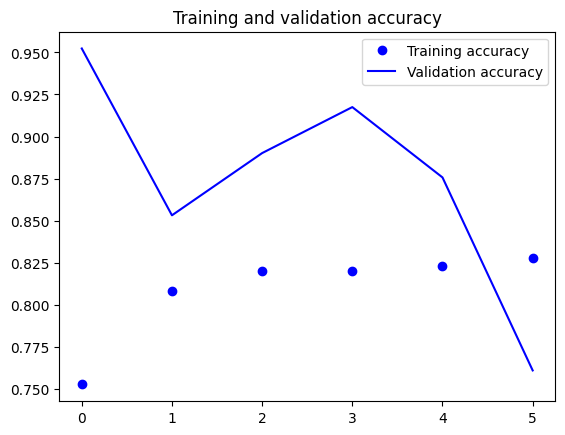

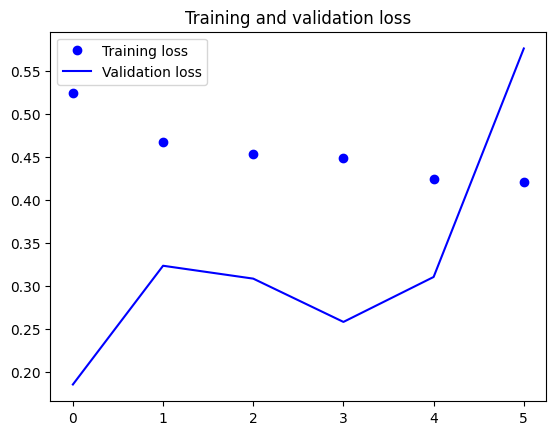

In [ ]:
run_model(model, "OneDense256_1dropout", epochs=30)

81/81 [==============================] - 22s 232ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.2757    0.4323      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.2757      2586
   macro avg     0.5000    0.1379    0.2161      2586
weighted avg     1.0000    0.2757    0.4323      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


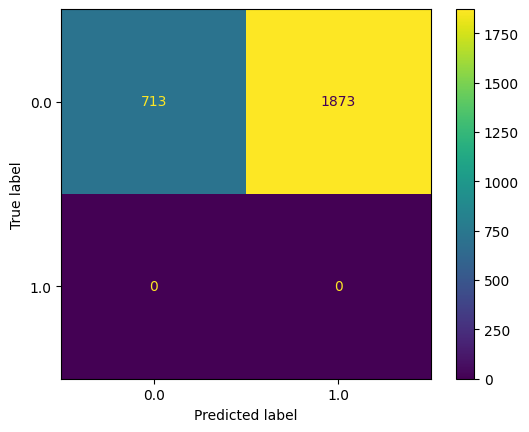

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense256_1dropout.h5'))

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 150, 150, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                      

Epoch 1/30
110/111 [============================>.] - ETA: 0s - loss: 0.5333 - accuracy: 0.7463
Epoch 1: val_loss improved from inf to 0.31663, saving model to /content/models/OneDense256_2dropout.h5
111/111 [==============================] - 28s 210ms/step - loss: 0.5332 - accuracy: 0.7465 - val_loss: 0.3166 - val_accuracy: 0.8757
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/111 [============================>.] - ETA: 0s - loss: 0.4667 - accuracy: 0.8085
Epoch 2: val_loss improved from 0.31663 to 0.26719, saving model to /content/models/OneDense256_2dropout.h5
111/111 [==============================] - 16s 137ms/step - loss: 0.4662 - accuracy: 0.8089 - val_loss: 0.2672 - val_accuracy: 0.9014
Epoch 3/30
110/111 [============================>.] - ETA: 0s - loss: 0.4546 - accuracy: 0.8082
Epoch 3: val_loss improved from 0.26719 to 0.26552, saving model to /content/models/OneDense256_2dropout.h5
111/111 [==============================] - 16s 141ms/step - loss: 0.4543 - accuracy: 0.8083 - val_loss: 0.2655 - val_accuracy: 0.9138
Epoch 4/30
110/111 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.8199
Epoch 4: val_loss did not improve from 0.26552
111/111 [==============================] - 17s 146ms/step - loss: 0.4433 - accuracy: 0.8194 - val_loss: 0.3618 - val_accuracy: 0.8768
Epoch 5/30
110/111 [============================>.] - ETA:

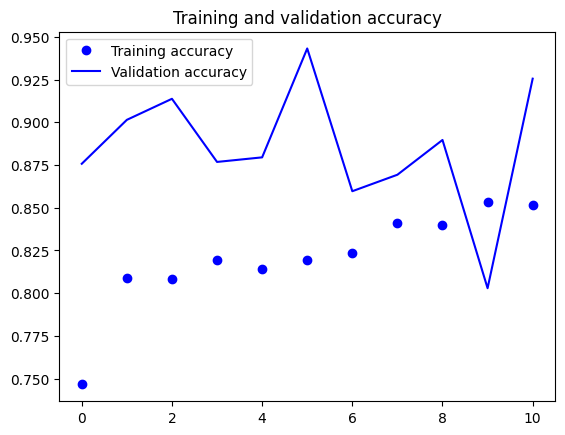

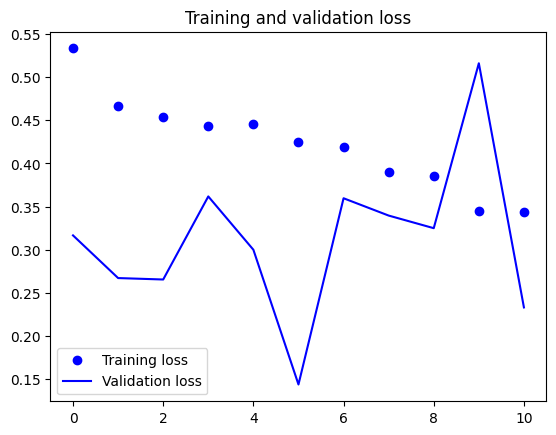

In [ ]:
run_model(model, "OneDense256_2dropout", epochs=30)

81/81 [==============================] - 18s 187ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.2831    0.4412      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.2831      2586
   macro avg     0.5000    0.1415    0.2206      2586
weighted avg     1.0000    0.2831    0.4412      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


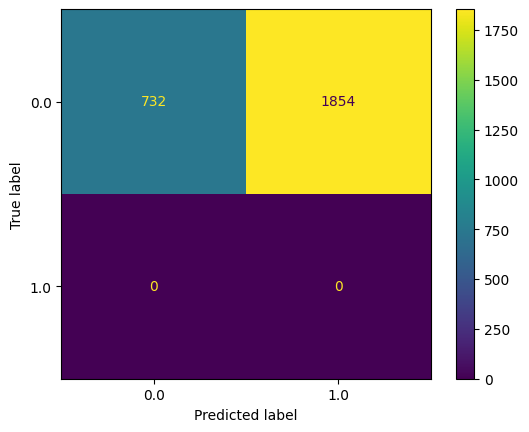

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense256_2dropout.h5'))